# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

/tmp/ipykernel_4034856/3464097013.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



OPENMP DISPLAY ENVIRONMENT BEGIN
  _OPENMP = '201511'
  OMP_DYNAMIC = 'FALSE'
  OMP_NESTED = 'FALSE'
  OMP_NUM_THREADS = '32'
  OMP_SCHEDULE = 'DYNAMIC'
  OMP_PROC_BIND = 'FALSE'
  OMP_PLACES = ''
  OMP_STACKSIZE = '0'
  OMP_WAIT_POLICY = 'PASSIVE'
  OMP_THREAD_LIMIT = '4294967295'
  OMP_MAX_ACTIVE_LEVELS = '1'
  OMP_CANCELLATION = 'FALSE'
  OMP_DEFAULT_DEVICE = '0'
  OMP_MAX_TASK_PRIORITY = '0'
  OMP_DISPLAY_AFFINITY = 'FALSE'
  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
OPENMP DISPLAY ENVIRONMENT END


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

# Condensate size

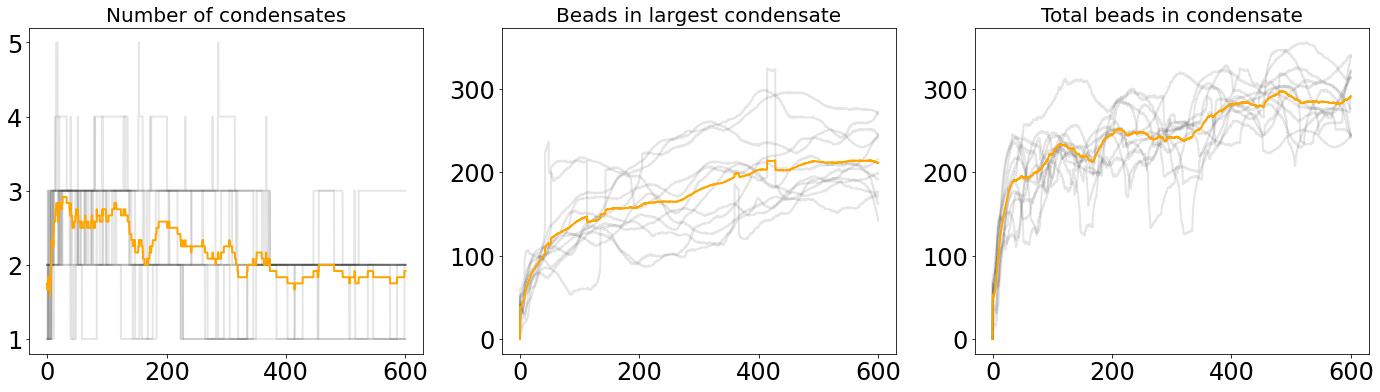

In [16]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"
ss_ind = 1
fig, axarr = plt.subplots(1,3, figsize=(24,6))
axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
    h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('**/*.h5')]
    
    for h5d in h5_data_lst:
        time_arr = h5d['time'][ss_ind:-1]
        
        cond_num_arr = h5d['analysis']['contact_cond_num'][...]
        edge_coords = h5d['analysis']['contact_cond_edges'][...]
        
        # Find the largest condensate by bead size at each time step
        if len(edge_coords) > 0:
            cond_widths_arr = edge_coords[:, 2] - edge_coords[:, 1]
        else:
            cond_widths_arr = np.asarray([])
        i_ec = 0  # index of edge_coord
        max_width_arr = []
        total_width_arr = []
        for i, t in np.ndenumerate(time_arr):
            max_width_arr += [0]
            total_width_arr += [0]
            # If the number of condensates at time step is zero, leave max width 0
            if cond_num_arr[i] == 0:
                continue
            # Iteratively check which is the largest condensate at a time step
            while edge_coords[i_ec, 0] < t and i_ec < cond_widths_arr.size:
                max_width_arr[-1] = max(max_width_arr[-1], cond_widths_arr[i_ec])
                total_width_arr[-1] += cond_widths_arr[i_ec]
                i_ec += 1
        if avg_cond_num is None:
            avg_cond_num = cond_num_arr[...]
            avg_max_width = np.asarray(max_width_arr)
            avg_total_bead = np.asarray(total_width_arr)
        else:
            avg_cond_num += cond_num_arr[...]
            avg_max_width += np.asarray(max_width_arr)
            avg_total_bead += np.asarray(total_width_arr)
            
        _ = axarr[0].plot(time_arr, cond_num_arr, color='k',alpha=.1)
        _ = axarr[1].plot(time_arr, max_width_arr, color='k',alpha=.1)
        _ = axarr[2].plot(time_arr, total_width_arr, color='k',alpha=.1)
    
        num_seeds += 1.
        
    _ = axarr[0].plot(time_arr, avg_cond_num/num_seeds, color='orange')
    _ = axarr[1].plot(time_arr, avg_max_width/num_seeds, color='orange')
    _ = axarr[2].plot(time_arr, avg_total_bead/num_seeds, color='orange')
    
    _ = axarr[0].set_title('Number of condensates')
    _ = axarr[1].set_title('Beads in largest condensate')
    _ = axarr[2].set_title('Total beads in condensate')
        
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

One way edge found for cond 5
One way edge found for cond 2
One way edge found for cond 11


(0.0, 5.587906563282013)

(0.0, 342.2)

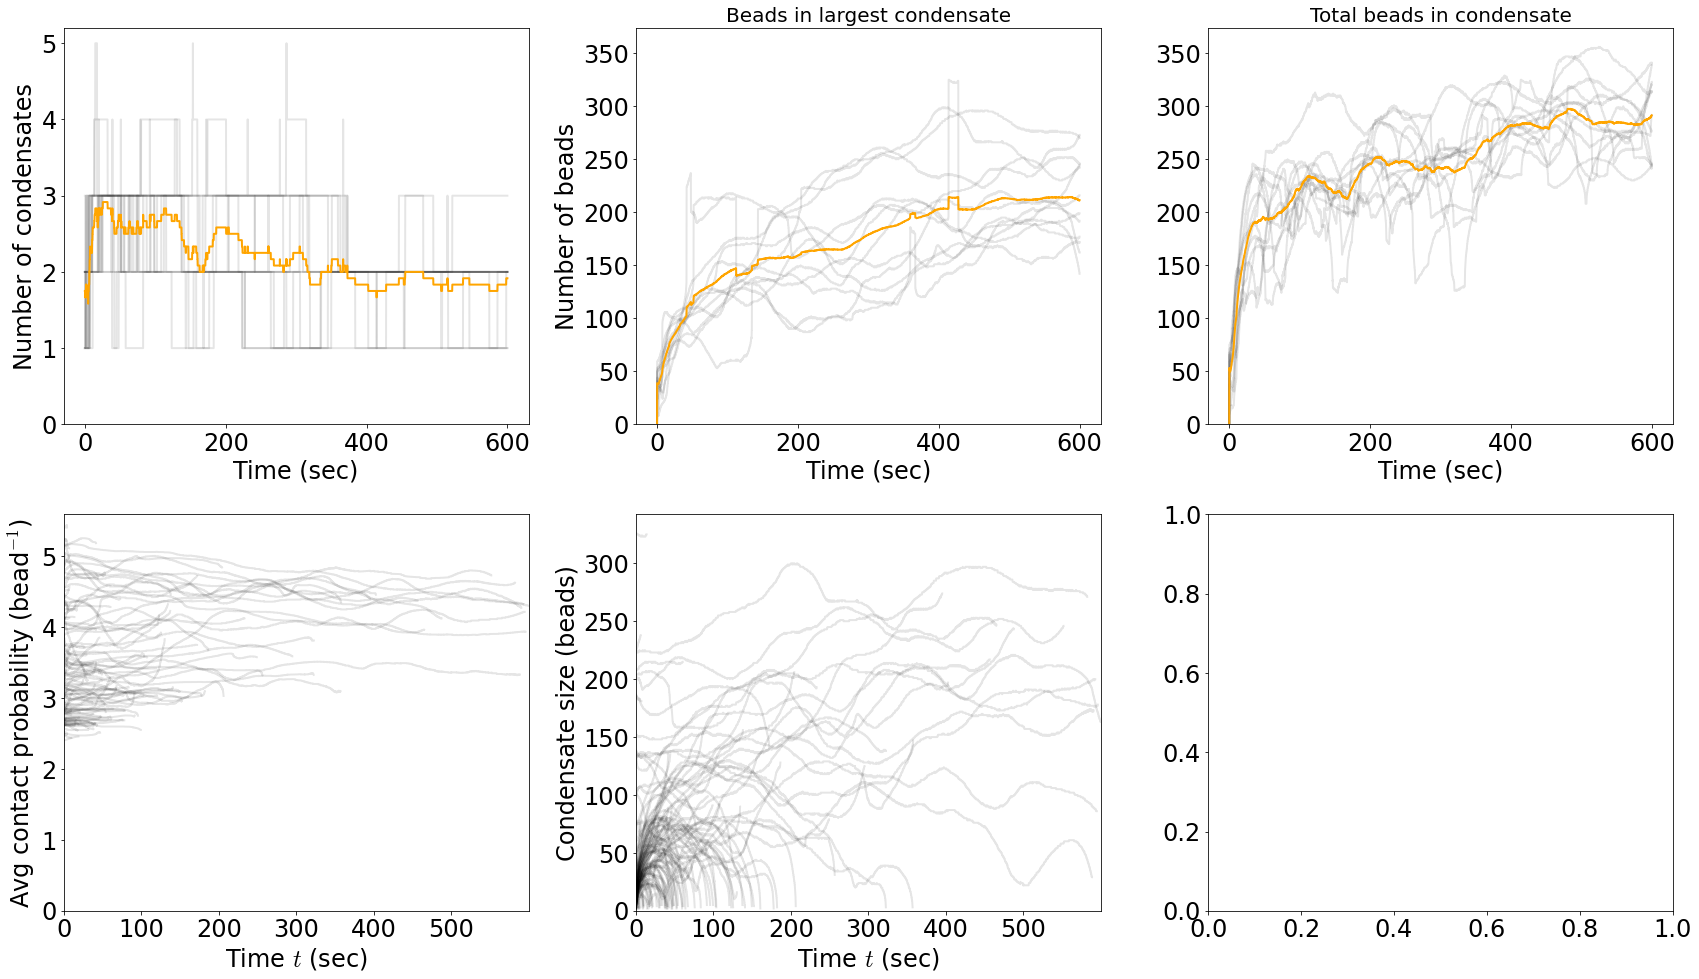

In [5]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]
        contact_cond_num = analysis_grp['contact_cond_num'][...]

        stored_condensates = aa.gen_condensate_track_info(time_arr, contact_cond_edges, contact_cond_num) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

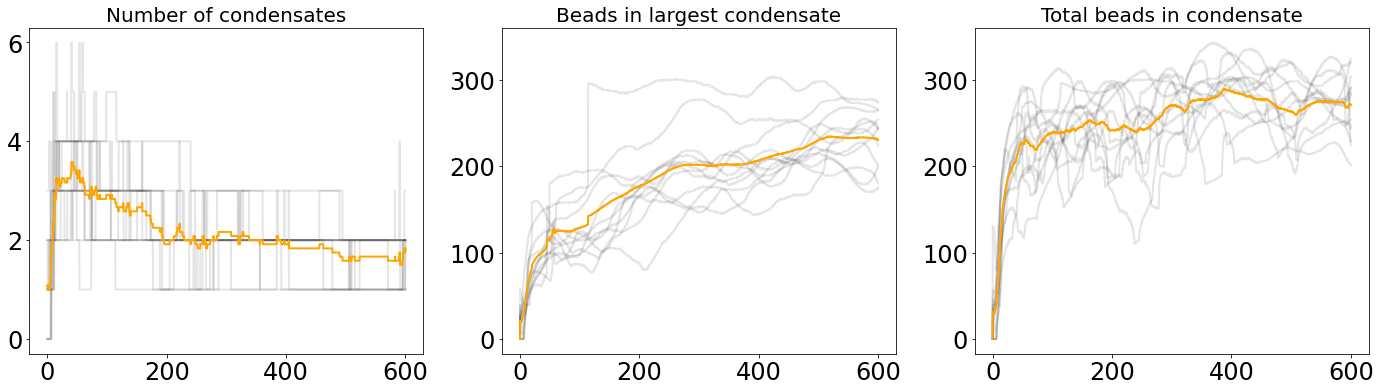

In [32]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_rigid20_conf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(1,3, figsize=(24,6))
axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
    h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('**/*.h5')]
    
    for h5d in h5_data_lst:
        time_arr = h5d['time'][ss_ind:-1]
        
        cond_num_arr = h5d['analysis']['contact_cond_num'][...]
        edge_coords = h5d['analysis']['contact_cond_edges'][...]
        
        # Find the largest condensate by bead size at each time step
        if len(edge_coords) > 0:
            cond_widths_arr = edge_coords[:, 2] - edge_coords[:, 1]
        else:
            cond_widths_arr = np.asarray([])
        i_ec = 0  # index of edge_coord
        max_width_arr = []
        total_width_arr = []
        for i, t in np.ndenumerate(time_arr):
            max_width_arr += [0]
            total_width_arr += [0]
            # If the number of condensates at time step is zero, leave max width 0
            if cond_num_arr[i] == 0:
                continue
            # Iteratively check which is the largest condensate at a time step
            while edge_coords[i_ec, 0] < t and i_ec < cond_widths_arr.size:
                max_width_arr[-1] = max(max_width_arr[-1], cond_widths_arr[i_ec])
                total_width_arr[-1] += cond_widths_arr[i_ec]
                i_ec += 1
        if avg_cond_num is None:
            avg_cond_num = cond_num_arr[...]
            avg_max_width = np.asarray(max_width_arr)
            avg_total_bead = np.asarray(total_width_arr)
        else:
            avg_cond_num += cond_num_arr[...]
            avg_max_width += np.asarray(max_width_arr)
            avg_total_bead += np.asarray(total_width_arr)
            
        _ = axarr[0].plot(time_arr, cond_num_arr, color='k',alpha=.1)
        _ = axarr[1].plot(time_arr, max_width_arr, color='k',alpha=.1)
        _ = axarr[2].plot(time_arr, total_width_arr, color='k',alpha=.1)
    
        num_seeds += 1.
        
    _ = axarr[0].plot(time_arr, avg_cond_num/num_seeds, color='orange')
    _ = axarr[1].plot(time_arr, avg_max_width/num_seeds, color='orange')
    _ = axarr[2].plot(time_arr, avg_total_bead/num_seeds, color='orange')
    
    _ = axarr[0].set_title('Number of condensates')
    _ = axarr[1].set_title('Beads in largest condensate')
    _ = axarr[2].set_title('Total beads in condensate')
        
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

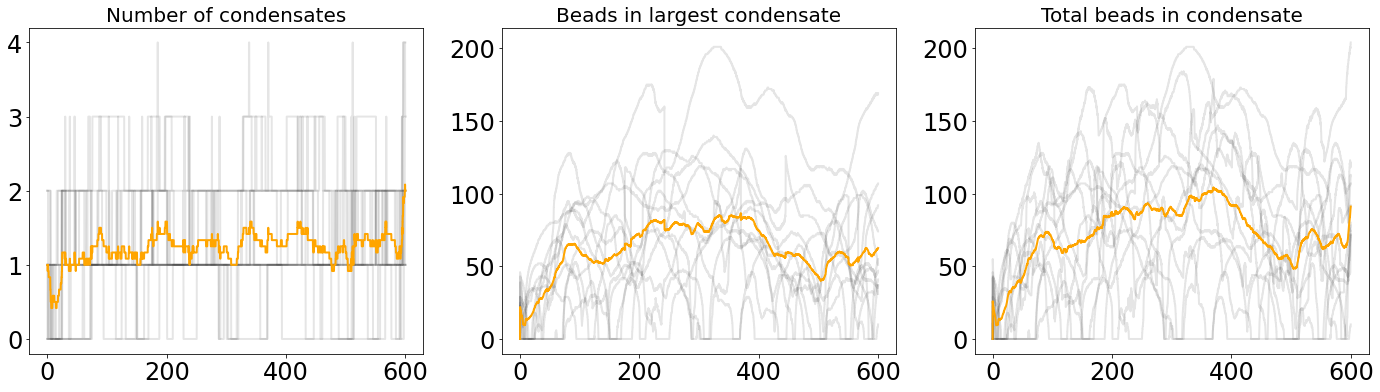

In [17]:
data_path = ceph_path / "21-12-01_aLchr1_scan.12_line700_sticky_2xKe_conf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(1,3, figsize=(24,6))
axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
    h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('**/*.h5')]
    
    for h5d in h5_data_lst:
        time_arr = h5d['time'][ss_ind:-1]
        
        cond_num_arr = h5d['analysis']['contact_cond_num'][...]
        edge_coords = h5d['analysis']['contact_cond_edges'][...]
        
        # Find the largest condensate by bead size at each time step
        if len(edge_coords) > 0:
            cond_widths_arr = edge_coords[:, 2] - edge_coords[:, 1]
        else:
            cond_widths_arr = np.asarray([])
        i_ec = 0  # index of edge_coord
        max_width_arr = []
        total_width_arr = []
        for i, t in np.ndenumerate(time_arr):
            max_width_arr += [0]
            total_width_arr += [0]
            # If the number of condensates at time step is zero, leave max width 0
            if cond_num_arr[i] == 0:
                continue
            # Iteratively check which is the largest condensate at a time step
            while edge_coords[i_ec, 0] < t and i_ec < cond_widths_arr.size:
                max_width_arr[-1] = max(max_width_arr[-1], cond_widths_arr[i_ec])
                total_width_arr[-1] += cond_widths_arr[i_ec]
                i_ec += 1
        if avg_cond_num is None:
            avg_cond_num = cond_num_arr[...]
            avg_max_width = np.asarray(max_width_arr)
            avg_total_bead = np.asarray(total_width_arr)
        else:
            avg_cond_num += cond_num_arr[...]
            avg_max_width += np.asarray(max_width_arr)
            avg_total_bead += np.asarray(total_width_arr)
            
        _ = axarr[0].plot(time_arr, cond_num_arr, color='k',alpha=.1)
        _ = axarr[1].plot(time_arr, max_width_arr, color='k',alpha=.1)
        _ = axarr[2].plot(time_arr, total_width_arr, color='k',alpha=.1)
    
        num_seeds += 1.
        
    _ = axarr[0].plot(time_arr, avg_cond_num/num_seeds, color='orange')
    _ = axarr[1].plot(time_arr, avg_max_width/num_seeds, color='orange')
    _ = axarr[2].plot(time_arr, avg_total_bead/num_seeds, color='orange')
    
    _ = axarr[0].set_title('Number of condensates')
    _ = axarr[1].set_title('Beads in largest condensate')
    _ = axarr[2].set_title('Total beads in condensate')
        
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

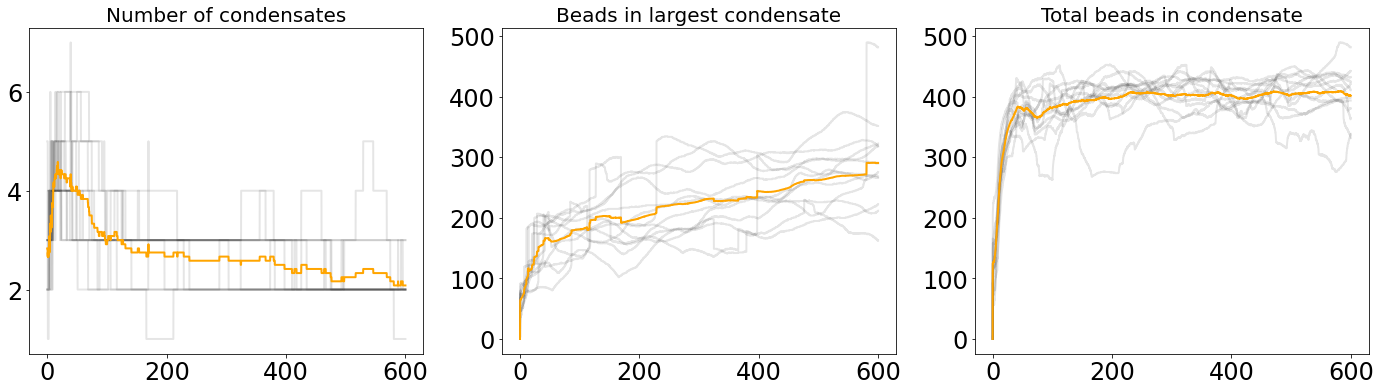

In [22]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(1,3, figsize=(24,6))
axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
    h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('**/*.h5')]
    
    for h5d in h5_data_lst:
        time_arr = h5d['time'][ss_ind:-1]
        
        cond_num_arr = h5d['analysis']['contact_cond_num'][...]
        edge_coords = h5d['analysis']['contact_cond_edges'][...]
        
        # Find the largest condensate by bead size at each time step
        if len(edge_coords) > 0:
            cond_widths_arr = edge_coords[:, 2] - edge_coords[:, 1]
        else:
            cond_widths_arr = np.asarray([])
        i_ec = 0  # index of edge_coord
        max_width_arr = []
        total_width_arr = []
        for i, t in np.ndenumerate(time_arr):
            max_width_arr += [0]
            total_width_arr += [0]
            # If the number of condensates at time step is zero, leave max width 0
            if cond_num_arr[i] == 0:
                continue
            # Iteratively check which is the largest condensate at a time step
            while edge_coords[i_ec, 0] < t and i_ec < cond_widths_arr.size:
                max_width_arr[-1] = max(max_width_arr[-1], cond_widths_arr[i_ec])
                total_width_arr[-1] += cond_widths_arr[i_ec]
                i_ec += 1
        if avg_cond_num is None:
            avg_cond_num = cond_num_arr[...]
            avg_max_width = np.asarray(max_width_arr)
            avg_total_bead = np.asarray(total_width_arr)
        else:
            avg_cond_num += cond_num_arr[...]
            avg_max_width += np.asarray(max_width_arr)
            avg_total_bead += np.asarray(total_width_arr)
            
        _ = axarr[0].plot(time_arr, cond_num_arr, color='k',alpha=.1)
        _ = axarr[1].plot(time_arr, max_width_arr, color='k',alpha=.1)
        _ = axarr[2].plot(time_arr, total_width_arr, color='k',alpha=.1)
    
        num_seeds += 1.
        
    _ = axarr[0].plot(time_arr, avg_cond_num/num_seeds, color='orange')
    _ = axarr[1].plot(time_arr, avg_max_width/num_seeds, color='orange')
    _ = axarr[2].plot(time_arr, avg_total_bead/num_seeds, color='orange')
    
    _ = axarr[0].set_title('Number of condensates')
    _ = axarr[1].set_title('Beads in largest condensate')
    _ = axarr[2].set_title('Total beads in condensate')
        
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

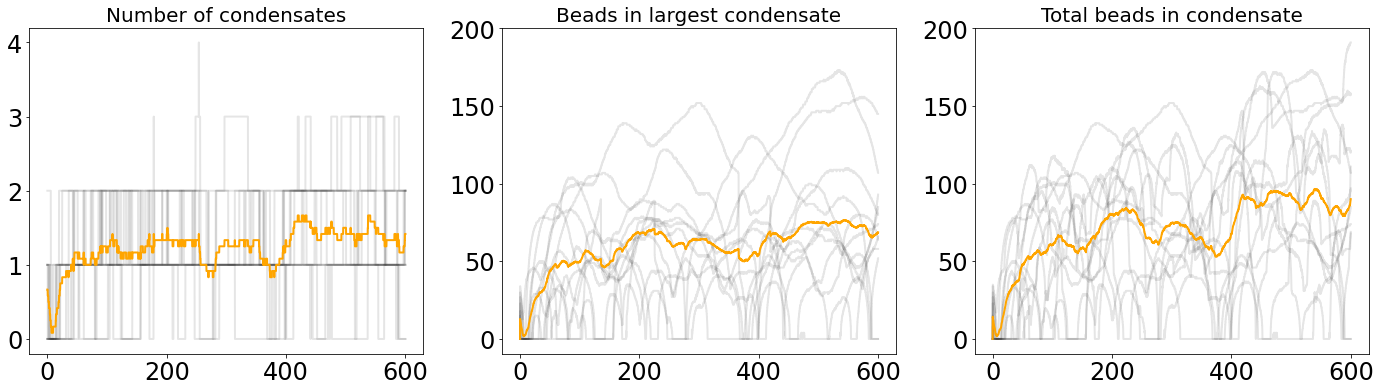

In [24]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_5umconf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(1,3, figsize=(24,6))
axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
    h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('**/*.h5')]
    
    for h5d in h5_data_lst:
        time_arr = h5d['time'][ss_ind:-1]
        
        cond_num_arr = h5d['analysis']['contact_cond_num'][...]
        edge_coords = h5d['analysis']['contact_cond_edges'][...]
        
        # Find the largest condensate by bead size at each time step
        if len(edge_coords) > 0:
            cond_widths_arr = edge_coords[:, 2] - edge_coords[:, 1]
        else:
            cond_widths_arr = np.asarray([])
        i_ec = 0  # index of edge_coord
        max_width_arr = []
        total_width_arr = []
        for i, t in np.ndenumerate(time_arr):
            max_width_arr += [0]
            total_width_arr += [0]
            # If the number of condensates at time step is zero, leave max width 0
            if cond_num_arr[i] == 0:
                continue
            # Iteratively check which is the largest condensate at a time step
            while edge_coords[i_ec, 0] < t and i_ec < cond_widths_arr.size:
                max_width_arr[-1] = max(max_width_arr[-1], cond_widths_arr[i_ec])
                total_width_arr[-1] += cond_widths_arr[i_ec]
                i_ec += 1
        if avg_cond_num is None:
            avg_cond_num = cond_num_arr[...]
            avg_max_width = np.asarray(max_width_arr)
            avg_total_bead = np.asarray(total_width_arr)
        else:
            avg_cond_num += cond_num_arr[...]
            avg_max_width += np.asarray(max_width_arr)
            avg_total_bead += np.asarray(total_width_arr)
            
        _ = axarr[0].plot(time_arr, cond_num_arr, color='k',alpha=.1)
        _ = axarr[1].plot(time_arr, max_width_arr, color='k',alpha=.1)
        _ = axarr[2].plot(time_arr, total_width_arr, color='k',alpha=.1)
    
        num_seeds += 1.
        
    _ = axarr[0].plot(time_arr, avg_cond_num/num_seeds, color='orange')
    _ = axarr[1].plot(time_arr, avg_max_width/num_seeds, color='orange')
    _ = axarr[2].plot(time_arr, avg_total_bead/num_seeds, color='orange')
    
    _ = axarr[0].set_title('Number of condensates')
    _ = axarr[1].set_title('Beads in largest condensate')
    _ = axarr[2].set_title('Total beads in condensate')
        
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s11/s11.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s12/s12.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s5/s5.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s9/s9.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s8/s8.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s7/s7.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s1/s1.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s4/s4.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations/s10/s10.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21

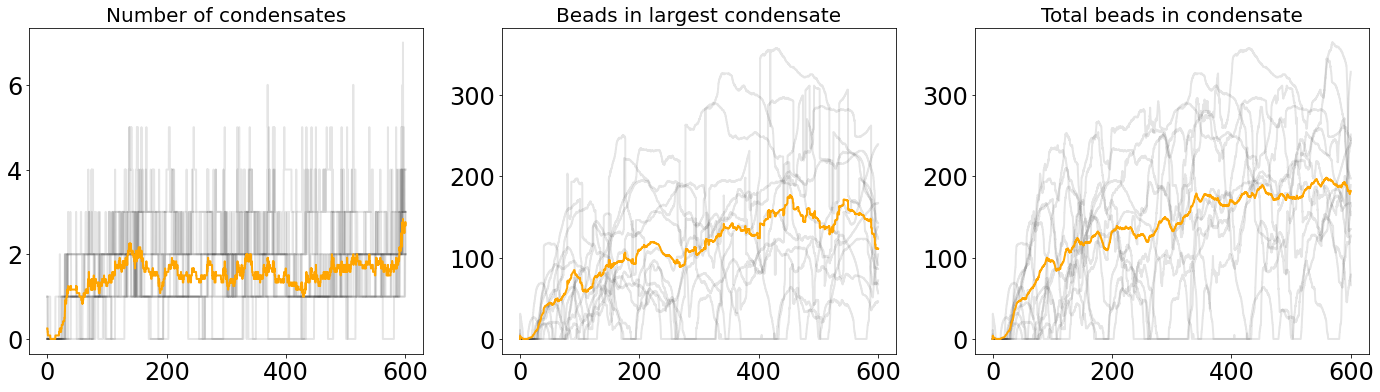

In [39]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(1,3, figsize=(24,6))
axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
    for h5_path in data_path.glob('**/*.h5'):
        with h5py.File(h5_path, 'r+') as h5d:
            print(h5_path)
    #h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('**/*.h5')]
    
   # for h5d in h5_data_lst:
            time_arr = h5d['time'][ss_ind:-1]

            cond_num_arr = h5d['analysis']['contact_cond_num'][...]
            edge_coords = h5d['analysis']['contact_cond_edges'][...]

            # Find the largest condensate by bead size at each time step
            if len(edge_coords) > 0:
                cond_widths_arr = edge_coords[:, 2] - edge_coords[:, 1]
            else:
                cond_widths_arr = np.asarray([])
            i_ec = 0  # index of edge_coord
            max_width_arr = []
            total_width_arr = []
            for i, t in np.ndenumerate(time_arr):
                max_width_arr += [0]
                total_width_arr += [0]
                # If the number of condensates at time step is zero, leave max width 0
                if cond_num_arr[i] == 0:
                    continue
                # Iteratively check which is the largest condensate at a time step
                while edge_coords[i_ec, 0] < t and i_ec < cond_widths_arr.size:
                    max_width_arr[-1] = max(max_width_arr[-1], cond_widths_arr[i_ec])
                    total_width_arr[-1] += cond_widths_arr[i_ec]
                    i_ec += 1
            if avg_cond_num is None:
                avg_cond_num = cond_num_arr[...]
                avg_max_width = np.asarray(max_width_arr)
                avg_total_bead = np.asarray(total_width_arr)
            else:
                avg_cond_num += cond_num_arr[...]
                avg_max_width += np.asarray(max_width_arr)
                avg_total_bead += np.asarray(total_width_arr)

            _ = axarr[0].plot(time_arr, cond_num_arr, color='k',alpha=.1)
            _ = axarr[1].plot(time_arr, max_width_arr, color='k',alpha=.1)
            _ = axarr[2].plot(time_arr, total_width_arr, color='k',alpha=.1)

            num_seeds += 1.
        
    _ = axarr[0].plot(time_arr, avg_cond_num/num_seeds, color='orange')
    _ = axarr[1].plot(time_arr, avg_max_width/num_seeds, color='orange')
    _ = axarr[2].plot(time_arr, avg_total_bead/num_seeds, color='orange')
    
    _ = axarr[0].set_title('Number of condensates')
    _ = axarr[1].set_title('Beads in largest condensate')
    _ = axarr[2].set_title('Total beads in condensate')
        
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s11/s11.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s12/s12.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s5/s5.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s9/s9.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s8/s8.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s7/s7.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s1/s1.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s4/s4.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations/s10/s10.h5
/mnt/home/alamson/ceph/DATA/Chromatin/21

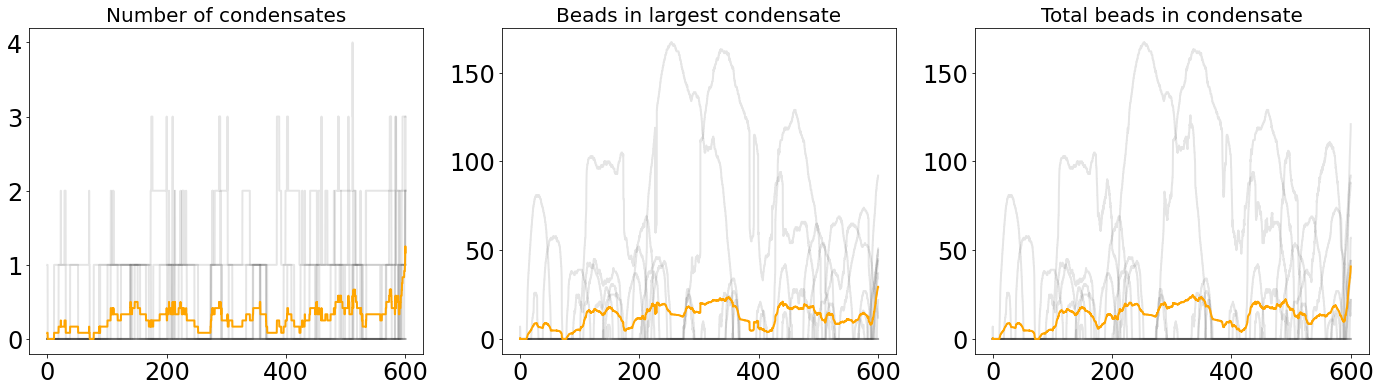

In [41]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_sticky_3umconf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(1,3, figsize=(24,6))
axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
    for h5_path in data_path.glob('**/*.h5'):
        with h5py.File(h5_path, 'r+') as h5d:
            print(h5_path)
    #h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('**/*.h5')]
    
   # for h5d in h5_data_lst:
            time_arr = h5d['time'][ss_ind:-1]

            cond_num_arr = h5d['analysis']['contact_cond_num'][...]
            edge_coords = h5d['analysis']['contact_cond_edges'][...]

            # Find the largest condensate by bead size at each time step
            if len(edge_coords) > 0:
                cond_widths_arr = edge_coords[:, 2] - edge_coords[:, 1]
            else:
                cond_widths_arr = np.asarray([])
            i_ec = 0  # index of edge_coord
            max_width_arr = []
            total_width_arr = []
            for i, t in np.ndenumerate(time_arr):
                max_width_arr += [0]
                total_width_arr += [0]
                # If the number of condensates at time step is zero, leave max width 0
                if cond_num_arr[i] == 0:
                    continue
                # Iteratively check which is the largest condensate at a time step
                while edge_coords[i_ec, 0] < t and i_ec < cond_widths_arr.size:
                    max_width_arr[-1] = max(max_width_arr[-1], cond_widths_arr[i_ec])
                    total_width_arr[-1] += cond_widths_arr[i_ec]
                    i_ec += 1
            if avg_cond_num is None:
                avg_cond_num = cond_num_arr[...]
                avg_max_width = np.asarray(max_width_arr)
                avg_total_bead = np.asarray(total_width_arr)
            else:
                avg_cond_num += cond_num_arr[...]
                avg_max_width += np.asarray(max_width_arr)
                avg_total_bead += np.asarray(total_width_arr)

            _ = axarr[0].plot(time_arr, cond_num_arr, color='k',alpha=.1)
            _ = axarr[1].plot(time_arr, max_width_arr, color='k',alpha=.1)
            _ = axarr[2].plot(time_arr, total_width_arr, color='k',alpha=.1)

            num_seeds += 1.
        
    _ = axarr[0].plot(time_arr, avg_cond_num/num_seeds, color='orange')
    _ = axarr[1].plot(time_arr, avg_max_width/num_seeds, color='orange')
    _ = axarr[2].plot(time_arr, avg_total_bead/num_seeds, color='orange')
    
    _ = axarr[0].set_title('Number of condensates')
    _ = axarr[1].set_title('Beads in largest condensate')
    _ = axarr[2].set_title('Total beads in condensate')
        
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

One way edge found for cond 5
Super merging event occured at cond 7
Super splitter event occured for cond 13
Super merging event occured at cond 6
Super merging event occured at cond 10


(0.0, 5.613284277915954)

(0.0, 515.45)

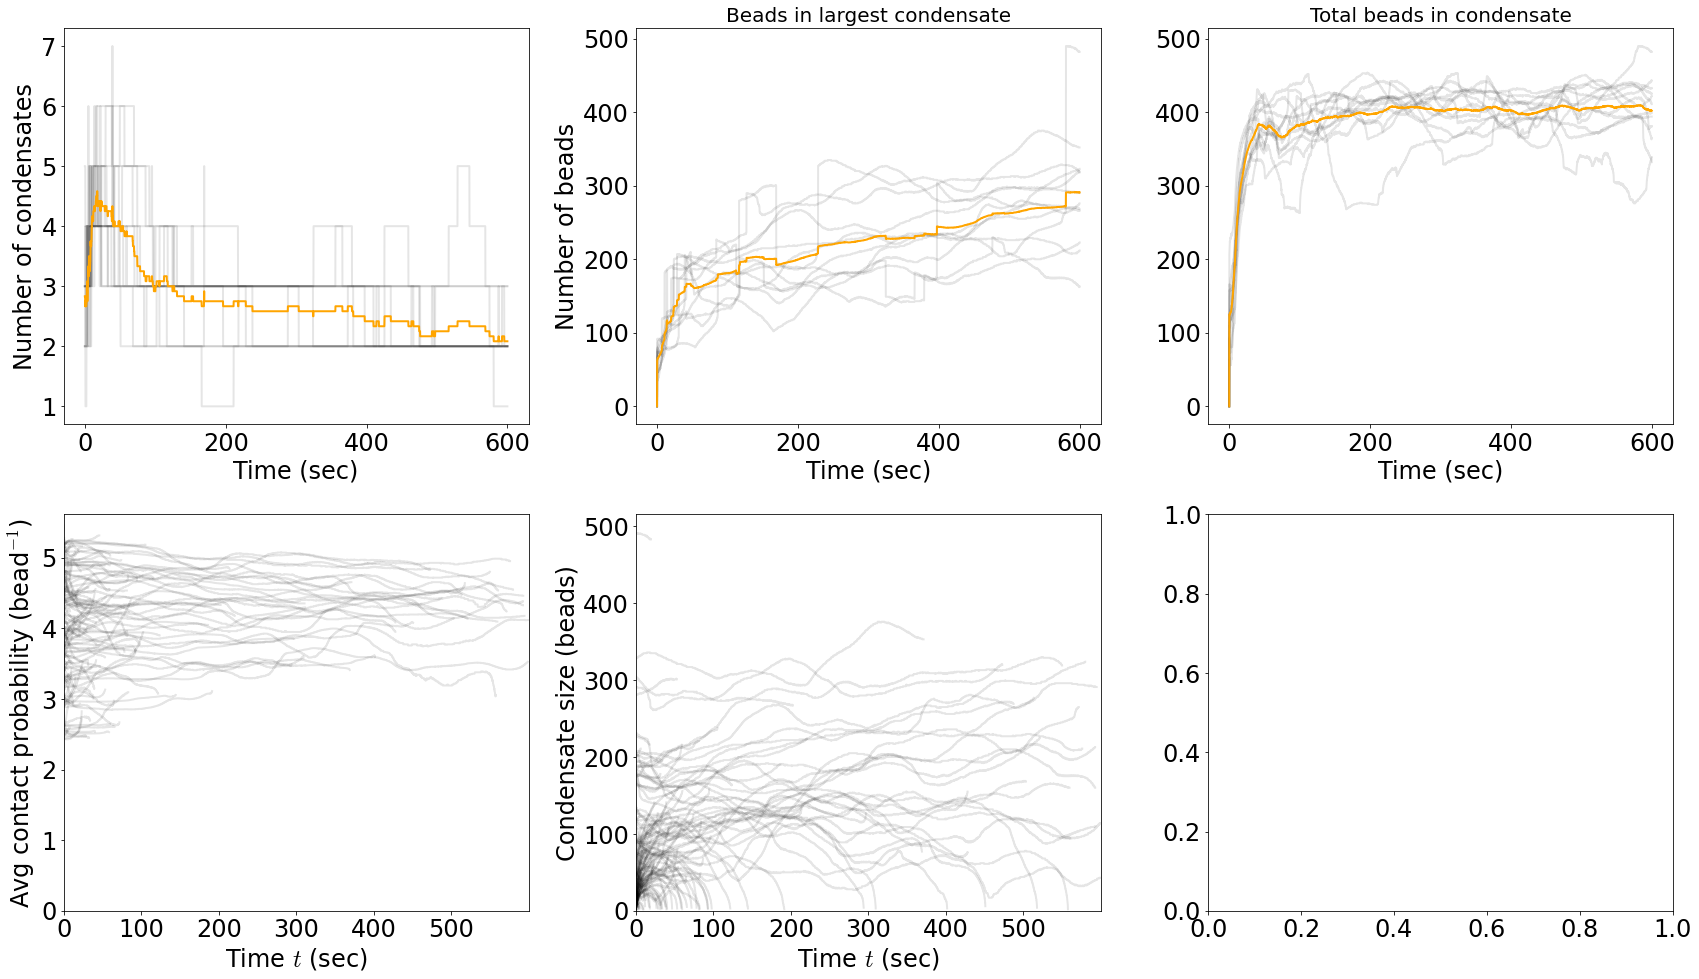

In [122]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]

        stored_condensates = aa.gen_condensate_track_info(h5_data) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

One way edge found for cond 18


(0.0, 4.328320908546448)

(0.0, 182.6)

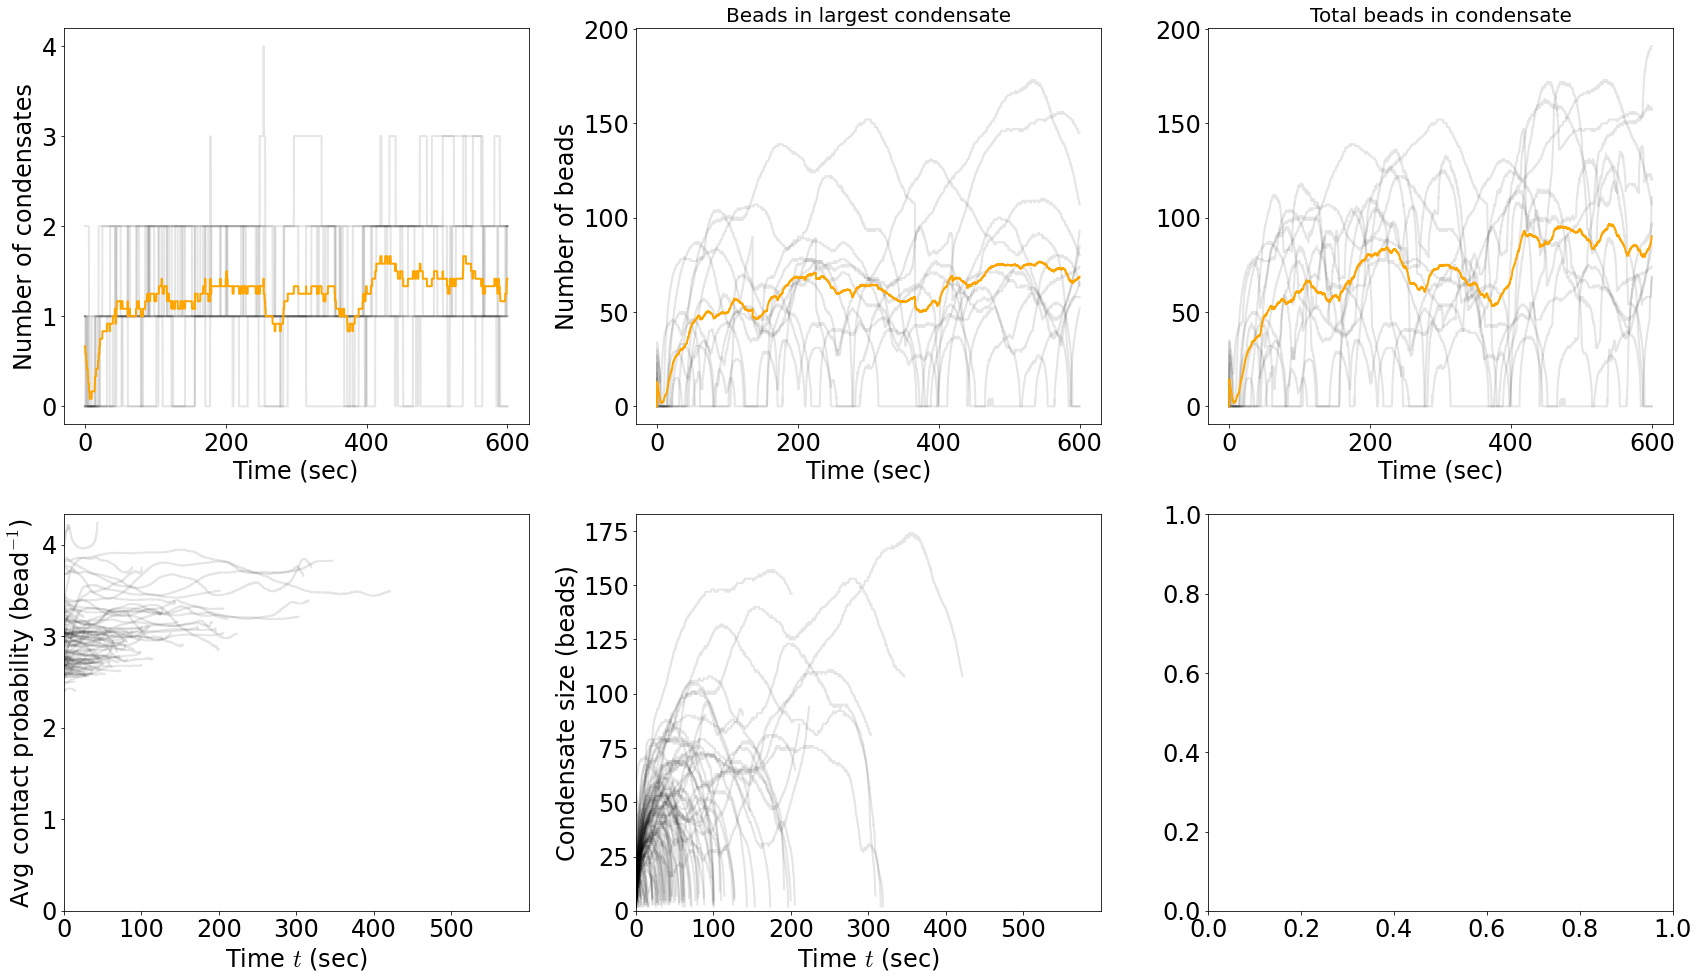

In [123]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_5umconf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]

        stored_condensates = aa.gen_condensate_track_info(h5_data) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)
    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

One way edge found for cond 5
One way edge found for cond 2
One way edge found for cond 11


(0.0, 5.587906563282013)

(0.0, 342.2)

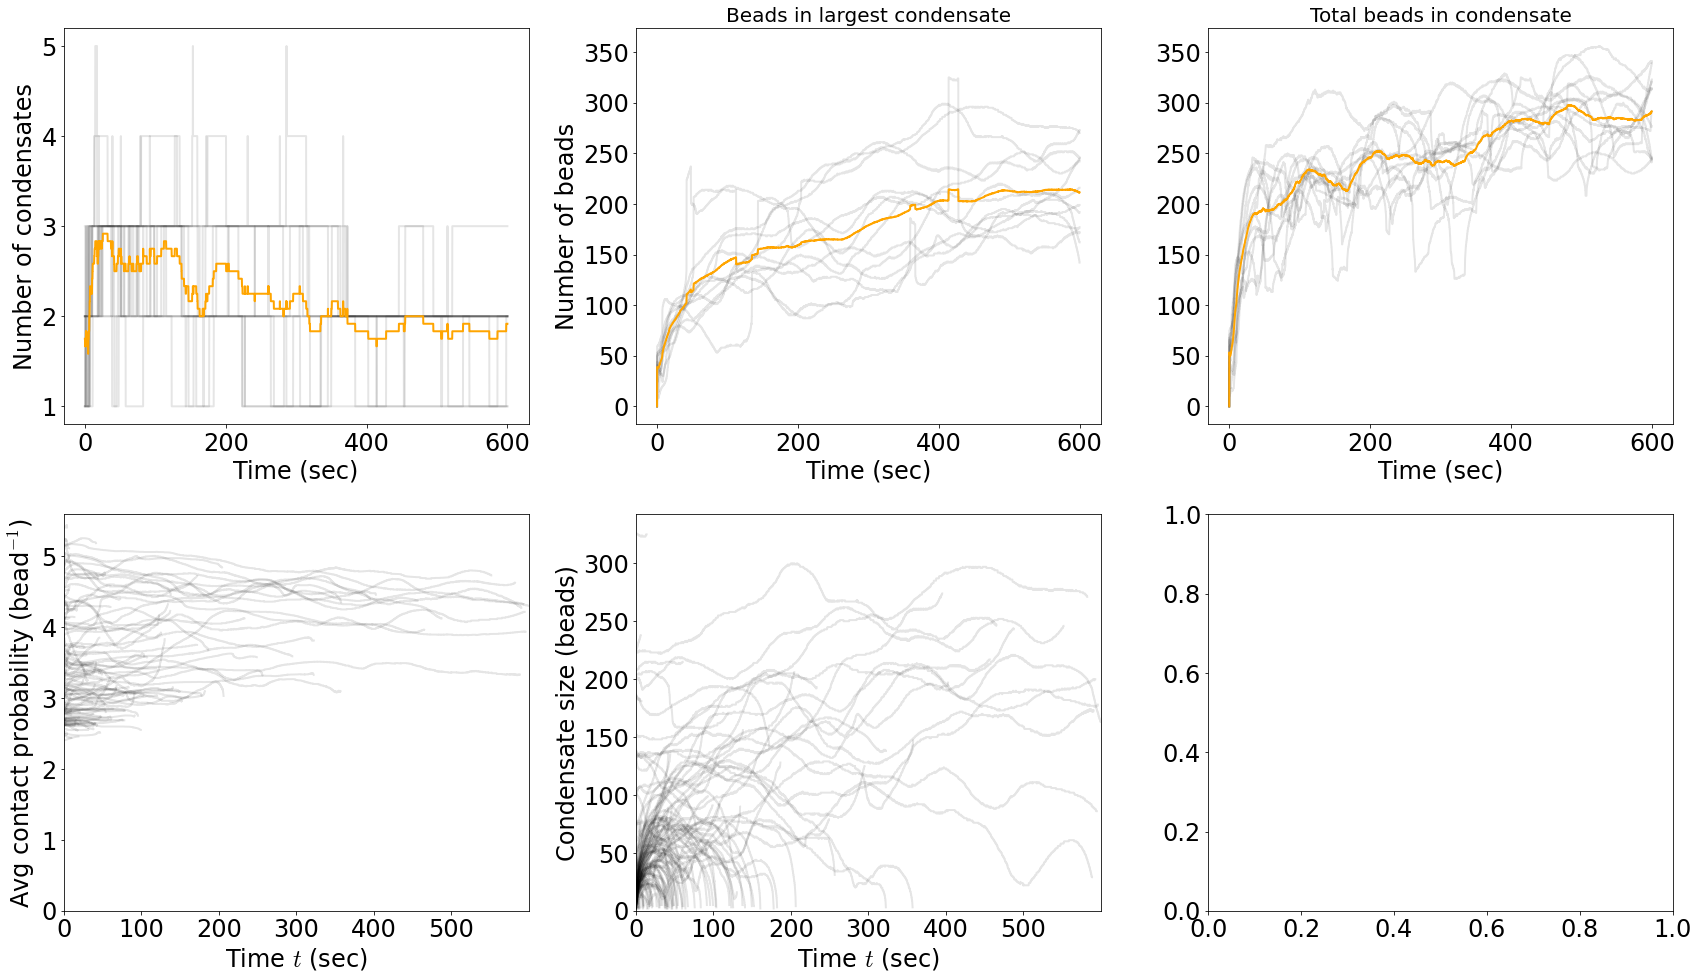

In [124]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]

        stored_condensates = aa.gen_condensate_track_info(h5_data) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

One way edge found for cond 58
One way edge found for cond 73
Super splitter event occured for cond 68
Super merging event occured at cond 104
Super splitter event occured for cond 104
One way edge found for cond 115
 Seed 6 failed to graph contact prob
 Seed 6 failed to graph size
One way edge found for cond 5
Super merging event occured at cond 21
Super splitter event occured for cond 38
Super merging event occured at cond 89
One way edge found for cond 20
One way edge found for cond 24
One way edge found for cond 3
One way edge found for cond 13
One way edge found for cond 44
One way edge found for cond 72
One way edge found for cond 4
One way edge found for cond 18
Super merging event occured at cond 69
Super splitter event occured for cond 7
One way edge found for cond 46
Super splitter event occured for cond 59
Super merging event occured at cond 24
Super merging event occured at cond 71
 Seed 8 failed to graph contact prob
 Seed 9 failed to graph contact prob
 Seed 8 failed to g

(0.0, 3.827096998691559)

(0.0, 375.8)

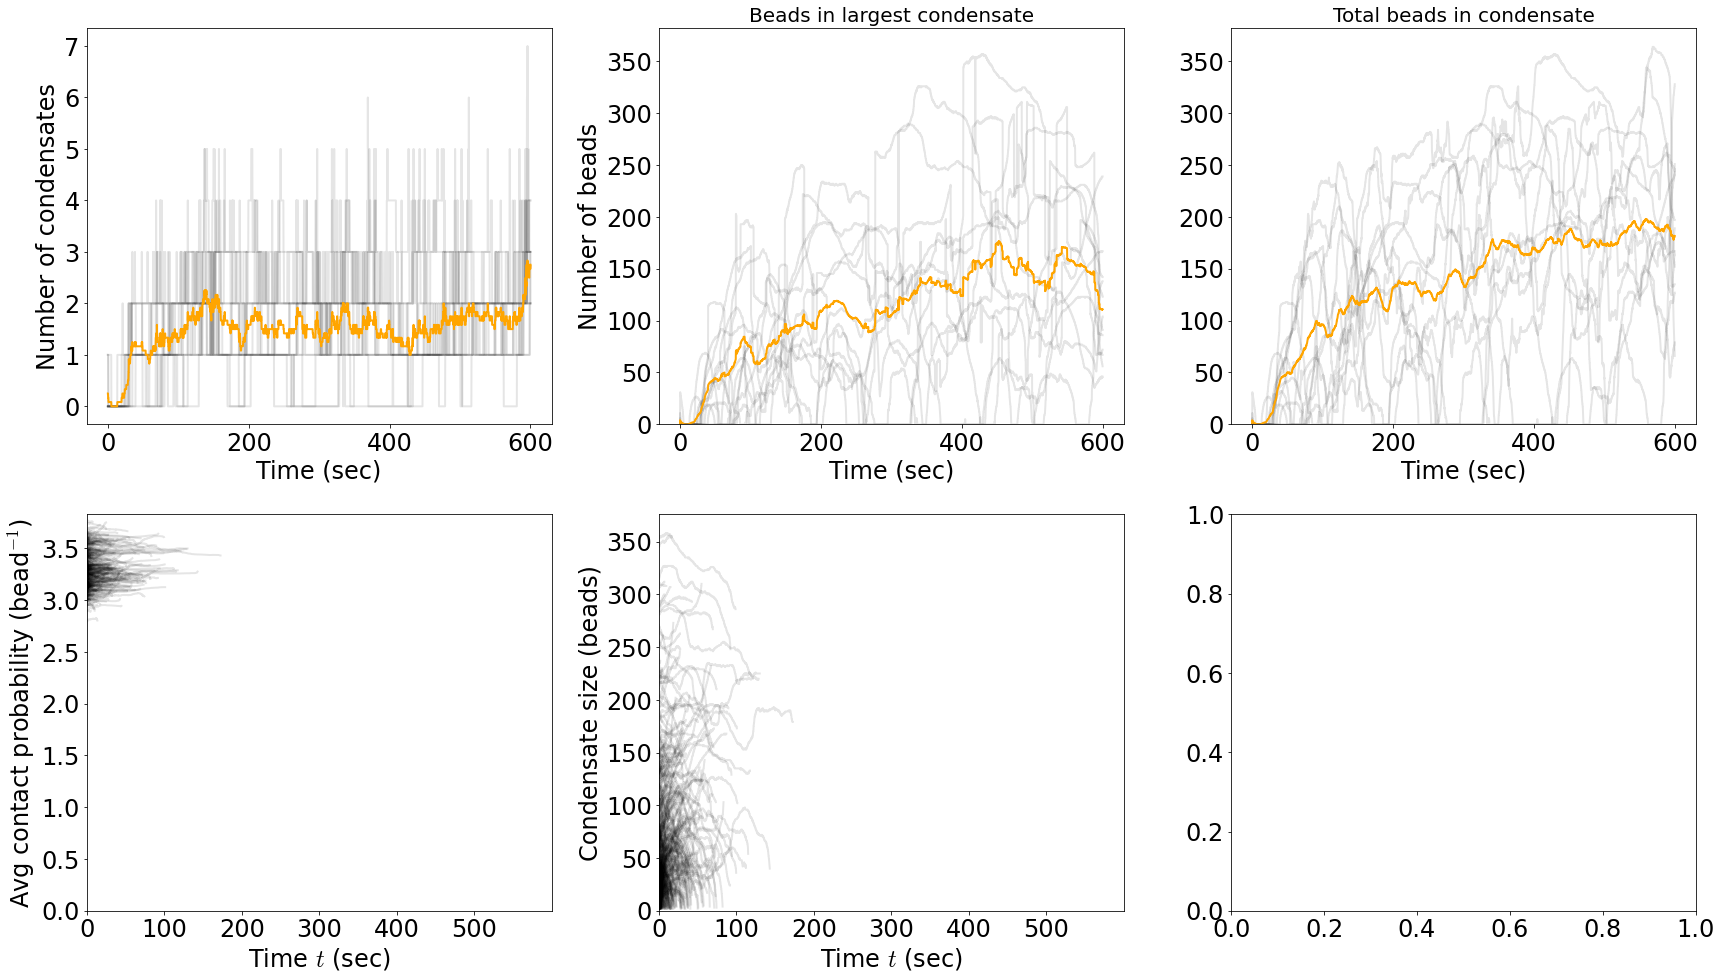

In [125]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_sticky_2umconf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]

        stored_condensates = aa.gen_condensate_track_info(h5_data) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

Super merging event occured at cond 5
One way edge found for cond 13


(0.0, 5.431228077411651)

(0.0, 319.1)

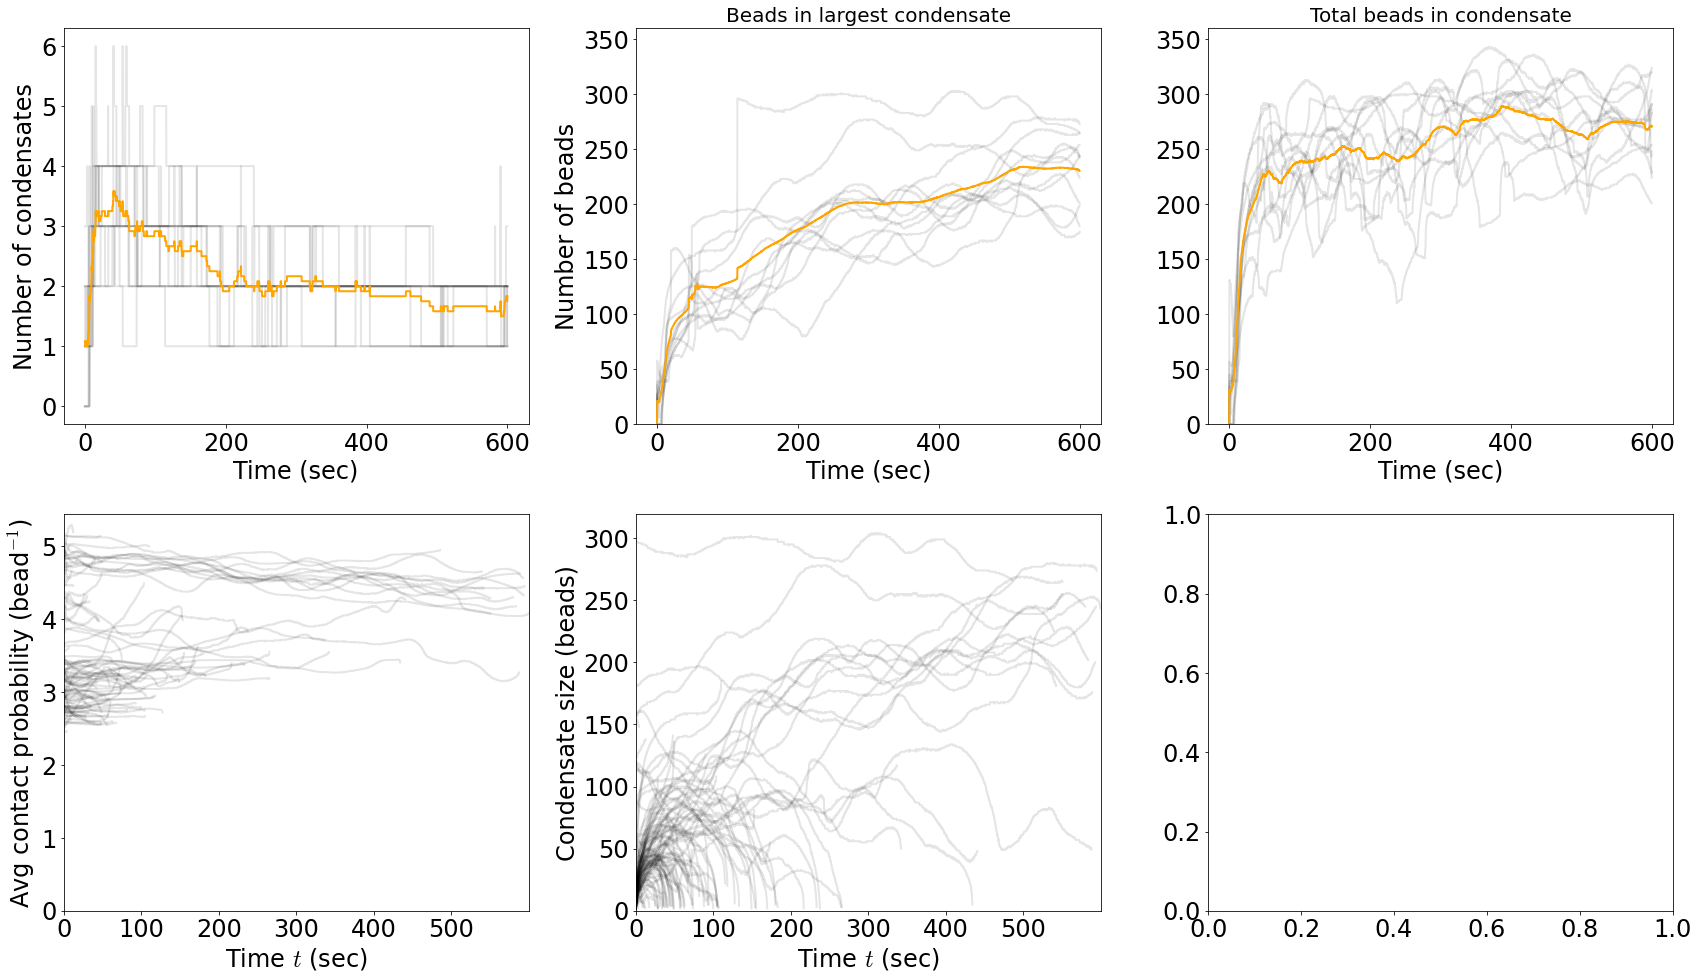

In [126]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_rigid20_conf/simulations"
ss_ind = 1
fig, axarr = plt.subplots(2,3, figsize=(24,14))
#axarr[1].sharey(axarr[2])
avg_cond_num = None
avg_max_width = None
avg_total_bead = None
num_seeds = 0.
h5_data_lst = []
try:
#     for h5_path in data_path.glob('**/*.h5'):
#         with h5py.File(h5_path, 'r+') as h5d:
#             print(h5_path)
    
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    sd_h5_data_lst.sort(key=aa.sd_num)
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    # TODO: Cludge - make this better
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]
    
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(
        sd_h5_data_lst)
    aa.plot_condensate_num_sd_scan(axarr[0,0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(
        axarr[0,1:], time_arr, max_width_arr, total_bead_arr)
    
    for h5_data in sd_h5_data_lst:
        analysis_grp = h5_data['analysis']

        contact_kymo = analysis_grp['contact_kymo'][...]
        nbeads = contact_kymo.shape[0]
        contact_cond_edges = analysis_grp['contact_cond_edges'][...]

        stored_condensates = aa.gen_condensate_track_info(h5_data) 
        aa.plot_condensate_avg_contact_vs_time(axarr[1,0], time_arr, contact_kymo, stored_condensates,
                                        same_start_flag=True, color='k', alpha=.1)
        aa.plot_condensate_size_vs_time(axarr[1,1], time_arr, stored_condensates, same_start_flag=True, color='k', alpha=.1)
    
    axarr[1,0].set_ylim(0)
    axarr[1,1].set_ylim(0)

    fig.tight_layout()
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0


/tmp/ipykernel_25037/2344760562.py:21: RuntimeWarning: divide by zero encountered in log
  log_avg_contact_mat = np.log(avg_contact_mat) - np.log(num_seeds)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


12.0


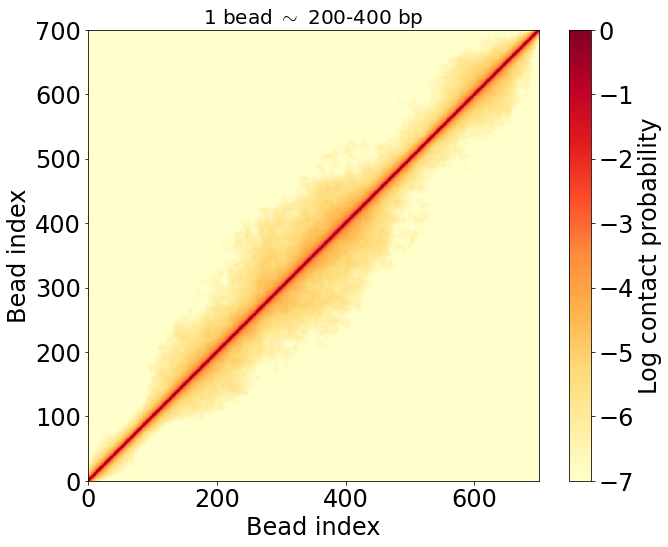

In [38]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"
ss_ind = 0
#fig, ax = plt.subplots(figsize=(8,6))
avg_contact_mat = None
num_seeds = 0.
h5_data_lst = []

try:
    for h5_path in data_path.glob('**/*.h5'):
        h5_data_lst += [h5py.File(h5_path, 'r+')]
    for h5d in h5_data_lst:
        is_log = h5d['analysis']['avg_contact_mat'].attrs['log']
        if avg_contact_mat is None:
            avg_contact_mat = h5d['analysis']['avg_contact_mat'][...] if not is_log else np.exp(h5d['analysis']['avg_contact_mat'][...])
        else:
            avg_contact_mat += h5d['analysis']['avg_contact_mat'][...] if not is_log else np.exp(h5d['analysis']['avg_contact_mat'][...])
        sy_dat = h5d['raw_data']['sylinders'][:None,:,ss_ind:]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        nbeads = com_arr.shape[0]
        num_seeds += 1.
    log_avg_contact_mat = np.log(avg_contact_mat) - np.log(num_seeds)
        
    fig, ax = aa.make_hic_plot(, log_avg_contact_mat, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

/mnt/home/alamson/projects/analysis/AMSOS_Analysis/amsos_analysis/chrom_seed_scan_analysis.py:95: RuntimeWarning: divide by zero encountered in log
  return log_avg_contact_mat


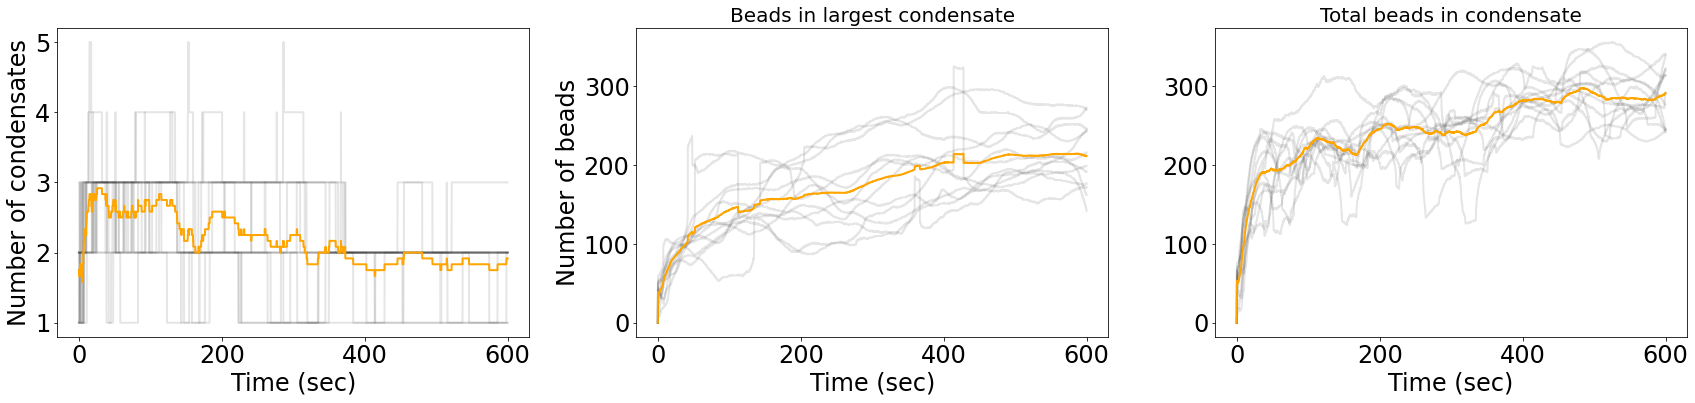

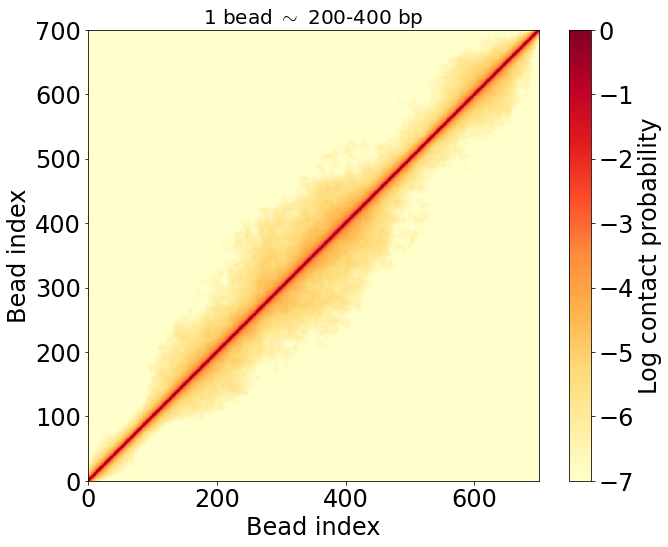

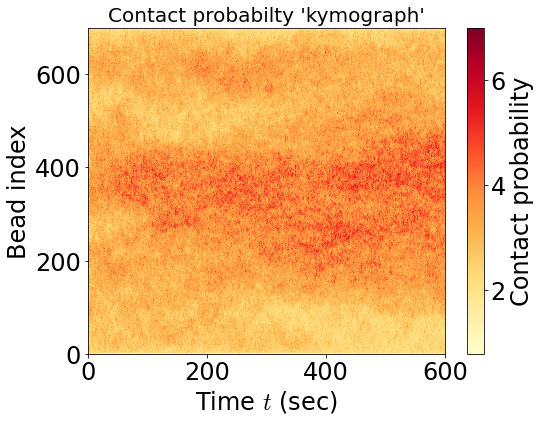

In [80]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"

try:
    sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in data_path.glob('s*/analysis/*.h5')]
    ss_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][0]
    end_ind = sd_h5_data_lst[0]['analysis/pos_kymo'].attrs['timestep_range'][1]
    time_arr = sd_h5_data_lst[0]['time'][ss_ind:end_ind]
    start_bead = 0
    end_bead = None
    nbeads = sd_h5_data_lst[0]['raw_data']['sylinders'][start_bead:end_bead, 0, 0].shape[0]

    fig1, axarr1 = plt.subplots(1, 3, figsize=(24, 6))
    cond_num_arr, max_width_arr, total_bead_arr = aa.get_scan_cond_data(sd_h5_data_lst)
    
    aa.plot_condensate_num_sd_scan(axarr1[0], time_arr, cond_num_arr)
    aa.plot_condensate_size_sd_scan(axarr1[1:], time_arr, max_width_arr, total_bead_arr)
    fig1.tight_layout()
    
    log_avg_contact_mat = aa.get_scan_avg_contact_mat(sd_h5_data_lst)
    fig2, ax2 = aa.make_hic_plot(nbeads, log_avg_contact_mat, vmin=-7.)
    
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    avg_contact_kymo = aa.get_scan_avg_kymo(sd_h5_data_lst)
    aa.plot_contact_kymo(fig3, ax3, time_arr, avg_contact_kymo, vmax=7.)
    #fig, ax = aa.make_hic_plot(com_arr, log_avg_contact_mat/num_seeds, vmin=-7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

## Average run tests

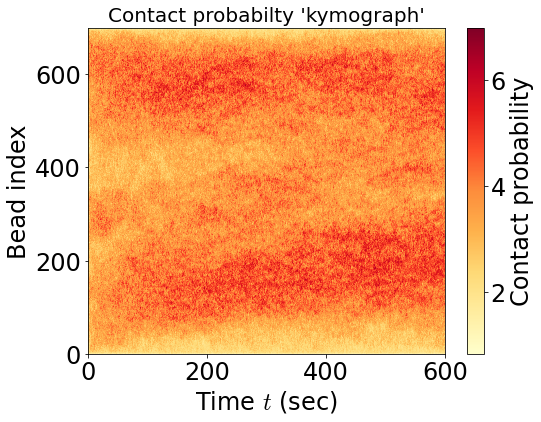

In [10]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/"
ss_ind = 0
fig, ax = plt.subplots(figsize=(8,6))
avg_contact_kymo = None
num_seeds = 0.
h5_data_lst = []

try:
    for h5_path in data_path.glob('s*/analysis/*.h5'):
        h5_data_lst += [h5py.File(h5_path, 'r+')]
    for h5d in h5_data_lst:
        if avg_contact_kymo is None:
            time_arr = h5d['time'][1:-1]
            avg_contact_kymo = h5d['analysis']['contact_kymo'][...]
        else:
            avg_contact_kymo += h5d['analysis']['contact_kymo'][...]
        num_seeds += 1.
        
    aa.plot_contact_kymo(fig, ax, time_arr, avg_contact_kymo/num_seeds, vmax=7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

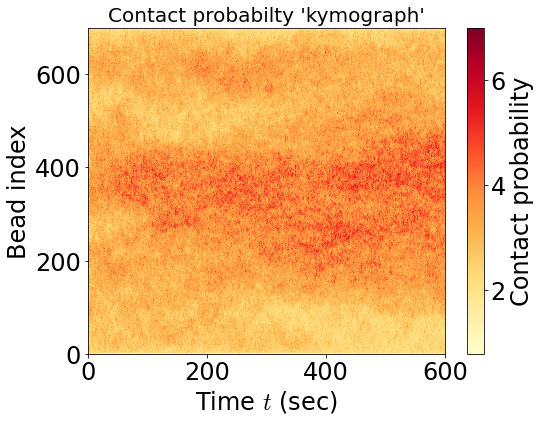

In [11]:
data_path = ceph_path / "21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/"
ss_ind = 0
fig, ax = plt.subplots(figsize=(8,6))
avg_contact_kymo = None
num_seeds = 0.
h5_data_lst = []

try:
    for h5_path in data_path.glob('s*/analysis/*.h5'):
        h5_data_lst += [h5py.File(h5_path, 'r+')]
    for h5d in h5_data_lst:
        if avg_contact_kymo is None:
            time_arr = h5d['time'][1:-1]
            avg_contact_kymo = h5d['analysis']['contact_kymo'][...]
        else:
            avg_contact_kymo += h5d['analysis']['contact_kymo'][...]
        num_seeds += 1.   
        
    aa.plot_contact_kymo(fig, ax, time_arr, avg_contact_kymo/num_seeds, vmax=7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

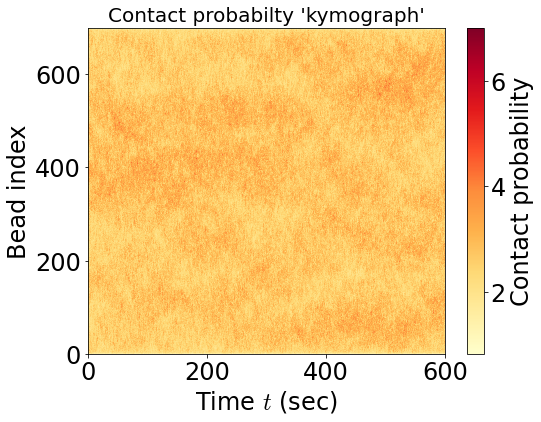

In [13]:
data_path = ceph_path / "21-12-05_aLchr1_scan.12_line700_2xsticky_5umconf/simulations/"
ss_ind = 0
fig, ax = plt.subplots(figsize=(8,6))
avg_contact_kymo = None
num_seeds = 0.
h5_data_lst = []

try:
    for h5_path in data_path.glob('s*/analysis/*.h5'):
        h5_data_lst += [h5py.File(h5_path, 'r+')]
    for h5d in h5_data_lst:
        if avg_contact_kymo is None:
            time_arr = h5d['time'][1:-1]
            avg_contact_kymo = h5d['analysis']['contact_kymo'][...]
        else:
            avg_contact_kymo += h5d['analysis']['contact_kymo'][...]
        num_seeds += 1.
        
    aa.plot_contact_kymo(fig, ax, time_arr, avg_contact_kymo/num_seeds, vmax=7.)
except:
    raise
finally:
    for h5d in h5_data_lst:
        h5d.close()

# Conclusions and Next Steps